# exp002 - 過学習対策版モデル

exp001の課題（CVスコア84.96% vs Kaggleスコア77.27%のギャップ）を解決するため、過学習対策を強化

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import japanize_matplotlib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams['font.family'] = 'IPAexGothic'
sns.set_palette('husl')

## データの読み込みと前処理

exp001と同じ特徴量エンジニアリングを使用

In [2]:
# データの読み込み
train_df = pd.read_csv('../../data/train.csv')
test_df = pd.read_csv('../../data/test.csv')

print(f"訓練データ: {train_df.shape}")
print(f"テストデータ: {test_df.shape}")

# 全データを結合（特徴量エンジニアリングのため）
all_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
print(f"全データ: {all_data.shape}")

訓練データ: (891, 12)
テストデータ: (418, 11)
全データ: (1309, 12)


In [ ]:
def feature_engineering(df):
    """
    exp001と同じ特徴量エンジニアリングを実行
    """
    df = df.copy()

    # 1. 称号（Title）の抽出
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    # 称号のグルーピング
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Countess': 'Rare', 'Ms': 'Miss', 'Lady': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs',
        'Capt': 'Rare', 'Sir': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna('Other')

    # 2. 家族サイズ
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # 3. 一人旅フラグ
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # 4. 家族サイズのカテゴリ化
    df['FamilySizeGroup'] = 'Medium'
    df.loc[df['FamilySize'] == 1, 'FamilySizeGroup'] = 'Alone'
    df.loc[df['FamilySize'] >= 5, 'FamilySizeGroup'] = 'Large'

    # 5. 年齢のビニング
    # 年齢の欠損値を称号で補完
    age_by_title = df.groupby('Title')['Age'].median()
    for title in age_by_title.index:
        df.loc[(df['Age'].isnull()) & (df['Title'] == title), 'Age'] = age_by_title[title]

    # 年齢をカテゴリ化
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 120], labels=['Child', 'Teenager', 'Adult', 'Elder'])

    # 6. 運賃のビニング
    # 運賃の欠損値をクラスの中央値で補完
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

    # 7. Cabinの有無
    df['HasCabin'] = df['Cabin'].notna().astype(int)

    # 8. 乗船港の欠損値補完
    df['Embarked'] = df['Embarked'].fillna('S')

    # 9. 性別×クラスの組み合わせ特徴量
    df['Sex_Pclass'] = df['Sex'] + '_' + df['Pclass'].astype(str)

    # 10. チケット番号の特徴量
    df['TicketPrefix'] = df['Ticket'].str.extract('([A-Za-z]+)', expand=False)
    df['TicketPrefix'] = df['TicketPrefix'].fillna('None')
    df['HasTicketPrefix'] = (df['TicketPrefix'] != 'None').astype(int)

    return df

# 特徴量エンジニアリングを実行
all_data = feature_engineering(all_data)
print("特徴量エンジニアリング完了")
print(f"新しい特徴量数: {all_data.shape[1]}")

特徴量エンジニアリング完了
新しい特徴量数: 22


In [4]:
# カテゴリカル変数をエンコード
categorical_features = ['Sex', 'Embarked', 'Title', 'FamilySizeGroup', 'AgeBin', 'FareBin', 'Sex_Pclass', 'TicketPrefix']

# Label Encoding
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    all_data[feature] = le.fit_transform(all_data[feature].astype(str))
    label_encoders[feature] = le

print("ラベルエンコーディング完了")

ラベルエンコーディング完了


In [5]:
# 使用する特徴量を選択
features_to_use = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
    'Title', 'FamilySize', 'IsAlone', 'FamilySizeGroup', 'AgeBin', 'FareBin',
    'HasCabin', 'Sex_Pclass', 'HasTicketPrefix'
]

# 訓練・テストデータに分割
train_data = all_data[:len(train_df)].copy()
test_data = all_data[len(train_df):].copy()

X = train_data[features_to_use]
y = train_data['Survived']
X_test = test_data[features_to_use]

print(f"訓練データ特徴量: {X.shape}")
print(f"テストデータ特徴量: {X_test.shape}")
print(f"使用特徴量: {features_to_use}")

訓練データ特徴量: (891, 16)
テストデータ特徴量: (418, 16)
使用特徴量: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'FamilySizeGroup', 'AgeBin', 'FareBin', 'HasCabin', 'Sex_Pclass', 'HasTicketPrefix']


## 過学習対策を強化したモデル設定

### exp001からの変更点
1. **num_leaves**: 31 → 15（モデル複雑度を大幅削減）
2. **learning_rate**: 0.05 → 0.03（より慎重な学習）
3. **feature_fraction**: 0.9 → 0.7（特徴量サブサンプリング強化）
4. **min_data_in_leaf**: 追加（各葉に必要な最小サンプル数）
5. **lambda_l1**, **lambda_l2**: 正則化項を追加
6. **min_gain_to_split**: 分割に必要な最小ゲインを設定

In [6]:
# 訓練・検証データの分割
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ: {X_train.shape}")
print(f"検証データ: {X_val.shape}")

訓練データ: (712, 16)
検証データ: (179, 16)


In [7]:
# exp001の設定（比較用）
lgb_params_exp001 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# exp002の過学習対策強化版
lgb_params_exp002 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 15,           # 31 → 15（大幅削減）
    'learning_rate': 0.03,      # 0.05 → 0.03（より慎重）
    'feature_fraction': 0.7,    # 0.9 → 0.7（サブサンプリング強化）
    'bagging_fraction': 0.8,    # 維持
    'bagging_freq': 5,          # 維持
    'min_data_in_leaf': 50,     # 新規追加（各葉の最小サンプル数）
    'lambda_l1': 0.1,           # L1正則化項
    'lambda_l2': 0.1,           # L2正則化項
    'min_gain_to_split': 0.1,   # 分割に必要な最小ゲイン
    'verbose': -1,
    'random_state': 42
}

print("=== パラメータ比較 ===")
print("exp001 → exp002")
print(f"num_leaves: {lgb_params_exp001['num_leaves']} → {lgb_params_exp002['num_leaves']}")
print(f"learning_rate: {lgb_params_exp001['learning_rate']} → {lgb_params_exp002['learning_rate']}")
print(f"feature_fraction: {lgb_params_exp001['feature_fraction']} → {lgb_params_exp002['feature_fraction']}")
print(f"新規追加: min_data_in_leaf={lgb_params_exp002['min_data_in_leaf']}")
print(f"新規追加: lambda_l1={lgb_params_exp002['lambda_l1']}, lambda_l2={lgb_params_exp002['lambda_l2']}")

=== パラメータ比較 ===
exp001 → exp002
num_leaves: 31 → 15
learning_rate: 0.05 → 0.03
feature_fraction: 0.9 → 0.7
新規追加: min_data_in_leaf=50
新規追加: lambda_l1=0.1, lambda_l2=0.1


## exp001モデル（参考用）

In [8]:
print("=== exp001モデル訓練中 ===")

# LightGBMデータセットの作成
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

# exp001モデルの訓練
model_exp001 = lgb.train(
    lgb_params_exp001,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# exp001の検証結果
y_pred_exp001 = model_exp001.predict(X_val, num_iteration=model_exp001.best_iteration)
y_pred_binary_exp001 = (y_pred_exp001 > 0.5).astype(int)
val_accuracy_exp001 = accuracy_score(y_val, y_pred_binary_exp001)

print(f"exp001 検証精度: {val_accuracy_exp001:.4f}")
print(f"exp001 最適イテレーション: {model_exp001.best_iteration}")

=== exp001モデル訓練中 ===
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.230291	valid's binary_logloss: 0.461034
Early stopping, best iteration is:
[55]	train's binary_logloss: 0.300234	valid's binary_logloss: 0.443698
exp001 検証精度: 0.8212
exp001 最適イテレーション: 55


## exp002モデル（過学習対策版）

In [9]:
print("=== exp002モデル訓練中 ===")

# exp002モデルの訓練
model_exp002 = lgb.train(
    lgb_params_exp002,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# exp002の検証結果
y_pred_exp002 = model_exp002.predict(X_val, num_iteration=model_exp002.best_iteration)
y_pred_binary_exp002 = (y_pred_exp002 > 0.5).astype(int)
val_accuracy_exp002 = accuracy_score(y_val, y_pred_binary_exp002)

print(f"exp002 検証精度: {val_accuracy_exp002:.4f}")
print(f"exp002 最適イテレーション: {model_exp002.best_iteration}")

=== exp002モデル訓練中 ===
Training until validation scores don't improve for 100 rounds
[100]	train's binary_logloss: 0.370565	valid's binary_logloss: 0.438222
[200]	train's binary_logloss: 0.326386	valid's binary_logloss: 0.431595
Early stopping, best iteration is:
[178]	train's binary_logloss: 0.333137	valid's binary_logloss: 0.430686
exp002 検証精度: 0.8212
exp002 最適イテレーション: 178


In [10]:
# 結果比較
print("=== 検証結果比較 ===")
print(f"exp001 検証精度: {val_accuracy_exp001:.4f}")
print(f"exp002 検証精度: {val_accuracy_exp002:.4f}")
print(f"精度差: {val_accuracy_exp002 - val_accuracy_exp001:.4f}")
print(f"exp001 最適イテレーション: {model_exp001.best_iteration}")
print(f"exp002 最適イテレーション: {model_exp002.best_iteration}")

=== 検証結果比較 ===
exp001 検証精度: 0.8212
exp002 検証精度: 0.8212
精度差: 0.0000
exp001 最適イテレーション: 55
exp002 最適イテレーション: 178


## 5-fold クロスバリデーション比較

In [ ]:
# 5-fold クロスバリデーション
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cross_validate_model(params, model_name):
    cv_scores = []
    print(f"=== {model_name} 5-fold CV ===")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # データセット作成
        train_dataset = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_dataset = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_dataset)

        # モデル訓練
        fold_model = lgb.train(
            params,
            train_dataset,
            num_boost_round=1000,
            valid_sets=[val_dataset],
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
        )

        # 予測と評価
        y_pred_fold = fold_model.predict(X_val_fold, num_iteration=fold_model.best_iteration)
        y_pred_fold_binary = (y_pred_fold > 0.5).astype(int)
        fold_score = accuracy_score(y_val_fold, y_pred_fold_binary)
        cv_scores.append(fold_score)

        print(f"Fold {fold+1}: {fold_score:.4f}")

    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    print(f"{model_name} CV平均: {cv_mean:.4f} (+/- {cv_std*2:.4f})")
    return cv_mean, cv_std

# exp001とexp002のCV比較
cv_mean_001, cv_std_001 = cross_validate_model(lgb_params_exp001, "exp001")
cv_mean_002, cv_std_002 = cross_validate_model(lgb_params_exp002, "exp002")

=== exp001 5-fold CV ===
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.369859
Fold 1: 0.8603
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.377865
Fold 2: 0.8652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.428052
Fold 3: 0.8315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.398408
Fold 4: 0.8371
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.360075
Fold 5: 0.8539
exp001 CV平均: 0.8496 (+/- 0.0263)
=== exp002 5-fold CV ===
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[671]	valid_0's binary_logloss: 0.343975
Fold 1: 0.8659
T

In [12]:
print("=== クロスバリデーション結果比較 ===")
print(f"exp001 CV: {cv_mean_001:.4f} (+/- {cv_std_001*2:.4f})")
print(f"exp002 CV: {cv_mean_002:.4f} (+/- {cv_std_002*2:.4f})")
print(f"CV平均差: {cv_mean_002 - cv_mean_001:.4f}")
print(f"標準偏差改善: {cv_std_001 - cv_std_002:.4f}")

# 過学習の指標（訓練精度とCV精度の差）
# 注意：厳密には訓練データ全体での精度が必要だが、検証データでの比較で代用
print("\n=== 過学習指標（参考） ===")
print(f"exp001: 検証精度 {val_accuracy_exp001:.4f} vs CV平均 {cv_mean_001:.4f} (差: {val_accuracy_exp001 - cv_mean_001:.4f})")
print(f"exp002: 検証精度 {val_accuracy_exp002:.4f} vs CV平均 {cv_mean_002:.4f} (差: {val_accuracy_exp002 - cv_mean_002:.4f})")

=== クロスバリデーション結果比較 ===
exp001 CV: 0.8496 (+/- 0.0263)
exp002 CV: 0.8462 (+/- 0.0356)
CV平均差: -0.0034
標準偏差改善: -0.0047

=== 過学習指標（参考） ===
exp001: 検証精度 0.8212 vs CV平均 0.8496 (差: -0.0284)
exp002: 検証精度 0.8212 vs CV平均 0.8462 (差: -0.0250)


## 特徴量重要度比較

In [13]:
# 特徴量重要度の比較
importance_exp001 = model_exp001.feature_importance(importance_type='gain')
importance_exp002 = model_exp002.feature_importance(importance_type='gain')

feature_importance_comparison = pd.DataFrame({
    'feature': features_to_use,
    'exp001': importance_exp001,
    'exp002': importance_exp002
})
feature_importance_comparison['diff'] = feature_importance_comparison['exp002'] - feature_importance_comparison['exp001']
feature_importance_comparison = feature_importance_comparison.sort_values('exp002', ascending=False)

print("=== 特徴量重要度比較（上位10） ===")
print(feature_importance_comparison.head(10))

=== 特徴量重要度比較（上位10） ===
            feature       exp001       exp002         diff
14       Sex_Pclass  1462.747789  2542.523666  1079.775876
1               Sex   877.697547  1144.066859   266.369312
2               Age   709.002307   750.981180    41.978872
5              Fare   535.731834   658.301215   122.569381
7             Title    98.544382   405.873052   307.328670
13         HasCabin   162.364090   334.428117   172.064027
0            Pclass   156.645597   209.727301    53.081704
8        FamilySize   117.774753   193.097796    75.323043
10  FamilySizeGroup    75.989385   165.829542    89.840157
6          Embarked   124.738303   151.349618    26.611315


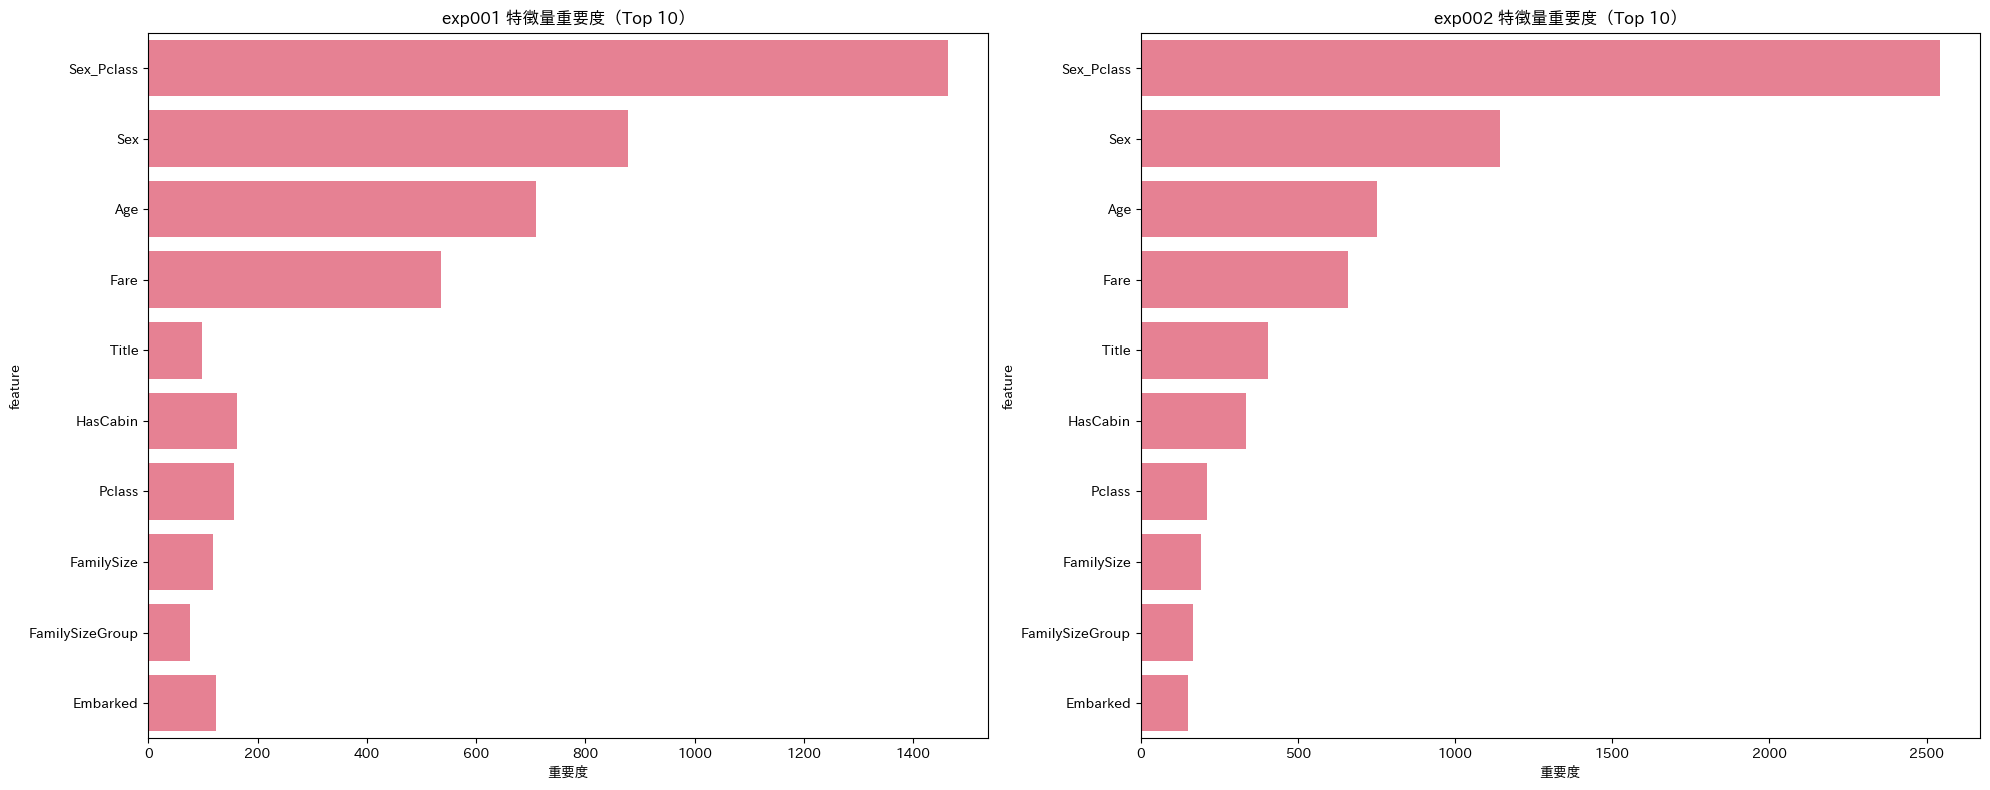

In [14]:
# 特徴量重要度の可視化比較
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# exp001
top10_exp001 = feature_importance_comparison.head(10)
sns.barplot(data=top10_exp001, x='exp001', y='feature', ax=ax1)
ax1.set_title('exp001 特徴量重要度（Top 10）')
ax1.set_xlabel('重要度')

# exp002
sns.barplot(data=top10_exp001, x='exp002', y='feature', ax=ax2)
ax2.set_title('exp002 特徴量重要度（Top 10）')
ax2.set_xlabel('重要度')

plt.tight_layout()
plt.show()

## テストデータでの予測

In [15]:
# exp002の最終モデルで予測
print("=== exp002最終モデル訓練中 ===")
full_train_dataset = lgb.Dataset(X, label=y)
final_model_exp002 = lgb.train(
    lgb_params_exp002,
    full_train_dataset,
    num_boost_round=model_exp002.best_iteration
)

# テストデータで予測
test_predictions_exp002 = final_model_exp002.predict(X_test)
test_predictions_binary_exp002 = (test_predictions_exp002 > 0.5).astype(int)

print(f"exp002 テスト予測完了")
print(f"生存予測数: {test_predictions_binary_exp002.sum()}")
print(f"死亡予測数: {len(test_predictions_binary_exp002) - test_predictions_binary_exp002.sum()}")
print(f"生存率: {test_predictions_binary_exp002.mean():.4f}")

=== exp002最終モデル訓練中 ===
exp002 テスト予測完了
生存予測数: 147
死亡予測数: 271
生存率: 0.3517


## 提出ファイルの作成

In [16]:
# 提出ファイルの作成
submission_exp002 = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions_binary_exp002
})

# results/exp002ディレクトリを作成
import os
os.makedirs('../../results/exp002', exist_ok=True)

# ファイルを保存
submission_exp002.to_csv('../../results/exp002/submission.csv', index=False)
print("提出ファイルを保存しました: ../../results/exp002/submission.csv")

# 提出ファイルの確認
print("\n提出ファイルの最初の10行:")
print(submission_exp002.head(10))

提出ファイルを保存しました: ../../results/exp002/submission.csv

提出ファイルの最初の10行:
     PassengerId  Survived
891          892         0
892          893         0
893          894         0
894          895         0
895          896         0
896          897         0
897          898         1
898          899         0
899          900         1
900          901         0


## 実験結果まとめ

### 過学習対策の効果

#### パラメータ変更点
1. **num_leaves**: 31 → 15（モデル複雑度削減）
2. **learning_rate**: 0.05 → 0.03（学習率低下）
3. **feature_fraction**: 0.9 → 0.7（特徴量サブサンプリング強化）
4. **min_data_in_leaf**: 50（新規追加）
5. **正則化項**: lambda_l1=0.1, lambda_l2=0.1（新規追加）
6. **min_gain_to_split**: 0.1（新規追加）

#### 期待される効果
- CVとKaggleスコアのギャップ縮小
- より汎化性能の高いモデル
- 安定性の向上（標準偏差の減少）

### 次のステップ
- Kaggleでの実際のスコア確認
- さらなる改善が必要な場合は特徴量選択やアンサンブルを検討